## Facial Keypoint detector

- Some of this code is modified from the Udacity Computer Vision Nanodegree facial keypoint detection project. 
- Some of the model training portions are modified from this [tutorial](https://debuggercafe.com/advanced-facial-keypoint-detection-with-pytorch/)

This notebook will show how to train a model to detect facial keypoints.


Facial keypoints (also called facial landmarks) are points that mark important areas of the face, such as the nose, mouth, eyes, and jawline. These key points have several applications, such as emotion recognition, pose recognition, face filters, and more. In each train and test image there is a single face with **68 keypoints mapped via (x,y) coordinates**. <br> <br> <br> 

                    
<center><img src='images/landmarks_numbered.jpg' width=30% height=30%/></center>

In [2]:
# import the required libraries
import glob
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [3]:
key_pts_df = pd.read_csv('data/training_frames_keypoints.csv')
key_pts_df.head()


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [4]:
idx = 0
image_name = key_pts_df.iloc[idx, 0]
key_pts = key_pts_df.iloc[idx, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2) # reshape to get 68 (x,y) coordinates

print(f'Image name: {image_name}')
print(f'Landmarks shape: {key_pts.shape}')

Image name: Luis_Fonsi_21.jpg
Landmarks shape: (68, 2)


#### Display some training images

In [5]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

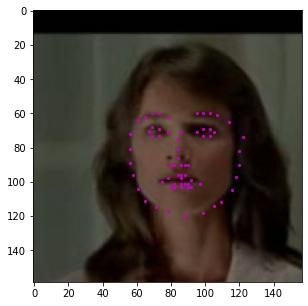

In [6]:
idx = 90
image_name = key_pts_df.iloc[idx, 0]
key_pts = key_pts_df.iloc[idx, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2) # reshape to get 68 (x,y) coordinates

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
plt.show()

In [7]:
tmp = mpimg.imread(os.path.join('data/training/', image_name))
print(tmp.dtype)
print(tmp.min())
print(tmp.max())

float32
0.0
1.0


In [8]:
tmp = cv2.imread(os.path.join('data/training/', image_name))
print(tmp.dtype)
print(tmp.min())
print(tmp.max())

uint8
0
119


In [9]:
tmp.shape

(159, 157, 3)

(159, 157, 3)


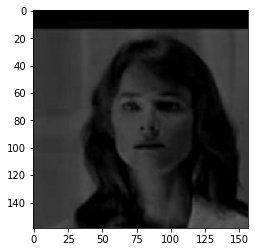

In [10]:
tmp2 = np.array([tmp[:, :, 0], tmp[:, :, 0], tmp[:, :, 0]]).transpose(1, 2, 0)
print(tmp2.shape)
plt.imshow(tmp2);

## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and NOT normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``RandomRotation`` : randomly rotates image and keypoints
-  ``ToTensor``: to convert numpy images to torch images.

Something else that we will do to the data is vary the location of the face in the training images only. This will be done by making the train Rescale size large compared to the random crop size, but not too large since we need the network to actually learn what entire faces look like.

For this training we will be using grayscale images with 3 layers repeated in order to fit the input to resnet. Since we are only using grayscale and not color we are feeding our model less information and we may expect lower performance from grayscale images than from rgb images.

The transform classes are in data_transforms.py

In [11]:
# get changes made to the external files
%load_ext autoreload
%autoreload 2

In [18]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# get custom dataset and transforms from helper file
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor, RandomRotate



train_transform = transforms.Compose([Rescale(275), # this needs to be larger compared random crop size
                                      RandomCrop(224),
                                      RandomRotate(50),
                                      Normalize(grayscale=True, mode=2),
                                      ToTensor()
                                     ])

test_transform = transforms.Compose([Rescale(255),
                                     RandomCrop(224),
                                     Normalize(grayscale=True, mode=2),
                                     ToTensor()
                                    ])

In [19]:
# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                       root_dir='data/training/',
                                       transform=train_transform)

test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                      root_dir='data/test/',
                                      transform=test_transform)


print(f'Number of training images: {len(train_dataset)}')
print(f'Number of test images: {len(test_dataset)}')

Number of training images: 3462
Number of test images: 770


In [20]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=0)

### Inspect some transformed training images
Below we will see that some of the images and their keypoints have been rotated

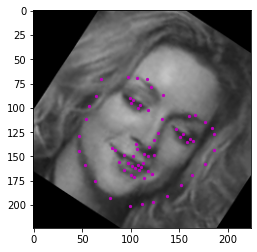

In [21]:
sample_dict = next(iter(train_loader))
sample_dict['image'].shape
# sample_dict['keypoints'].shape

idx = 1
img = sample_dict['image'][idx].squeeze().numpy().transpose((1, 2, 0))
kpt = sample_dict['keypoints'][idx]

# unnormalize rgb image
# img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]

# undo normalization of keypoints  
# kpt = kpt*50.0+100

plt.imshow(img)
plt.scatter(kpt[:, 0], kpt[:, 1], s=20, marker='.', c='m');

## Build the model
For this model we will use transfer learning and start with a resnet50 and modify the final layer.

In [22]:
import torchvision.models as models

resnet = models.resnet50(pretrained=True)

In [23]:
for name, child in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


#### Modify the final layer in order to get the correct outputs

In [24]:
resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [25]:
resnet.fc = nn.Linear(2048, 136)

### Freeze and unfreeze layers for training

In [26]:
def unfreeze_layers(model, layers):
    ''' unfreezes any layer contained in layers '''

    for name, child in model.named_children():
        if name in layers:
            print(f'{name} has been unfrozen')
            for param in child.parameters():
                param.requires_grad = True

        else:
            # freeze remaining layers
            print(f'{name} has been frozen')
            for param in child.parameters():
                param.requires_grad = False

In [27]:
train_layers = ['layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']

# if you want to train all parameters don't call this
unfreeze_layers(resnet, train_layers)

conv1 has been frozen
bn1 has been frozen
relu has been frozen
maxpool has been frozen
layer1 has been unfrozen
layer2 has been unfrozen
layer3 has been unfrozen
layer4 has been unfrozen
avgpool has been unfrozen
fc has been unfrozen


## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [28]:
# test the model on a batch of test images

def get_sample_output(model):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = model(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [29]:
test_images, test_outputs, gt_pts = get_sample_output(resnet)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 3, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [30]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

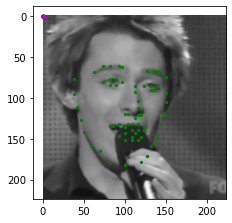

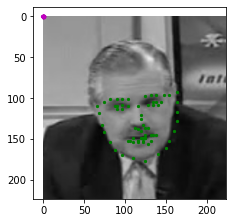

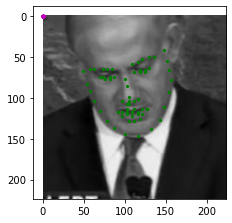

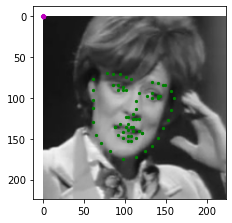

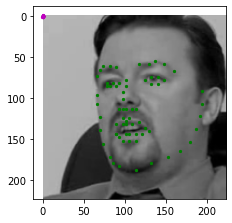

In [32]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # unnormalize rgb image (there may be some roundoff error here, just let Python clip values for displaying)
        # image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        # predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            # ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        # plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [33]:
tmp = test_images[0].data   # get the image from it's wrapper
tmp = tmp.numpy()   # convert to numpy array from a Tensor
tmp = np.transpose(tmp, (1, 2, 0))   # transpose to go from torch to numpy image

# unnormalize image
tmp = (tmp * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]

print(tmp.min())
print(tmp.max())
print(tmp.mean())
print(tmp.std())

0.4192352941669524
0.7113058825135231
0.5325396945170976
0.04881216071609148


We can see that the untrained output has a nice spread about the center of each image. Much better than a naive untraine dmodel which displays a very small cluster around the center (akin to a small dot).

## Start Training

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# place model on device
resnet = resnet.to(device)

cuda


In [35]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.SmoothL1Loss() # nn.MSELoss()

optimizer = optim.Adam(resnet.parameters(), lr=0.0005)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [36]:
# training function
def train(model, dataloader, epoch):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
  
    for i, data in enumerate(dataloader):
        counter += 1
        images = data['image']
        key_pts = data['keypoints']
        images, key_pts = images.to(device), key_pts.to(device)

        # convert variables to floats for regression loss
        if device == 'cuda':
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)
        else:
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

        # flatten the keypoints
        key_pts = key_pts.view(key_pts.size(0), -1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, key_pts)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

        # display loss
        if i % 50 == 49:    # print every 50 batches
            print('\t Epoch: {}, Batch: {}, Avg. Train Loss: {}'.format(epoch + 1, i+1, train_running_loss/counter))
        
    train_loss = train_running_loss/counter
    return train_loss

In [37]:
# validatioon function
def validate(model, dataloader, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            images = data['image']
            key_pts = data['keypoints']
            images, key_pts = images.to(device), key_pts.to(device)

            # convert variables to floats for regression loss
            if device == 'cuda':
                key_pts = key_pts.type(torch.cuda.FloatTensor)
                images = images.type(torch.cuda.FloatTensor)
            else:
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)

            # flatten the keypoints
            key_pts = key_pts.view(key_pts.size(0), -1)

            outputs = model(images)
            loss = criterion(outputs, key_pts)
            valid_running_loss += loss.item()

            # display loss
            if i % 20 == 19:    # print every 20 batches
                print('\t Epoch: {}, Batch: {}, Avg. Valid Loss: {}'.format(epoch + 1, i+1, valid_running_loss/counter))
        
    valid_loss = valid_running_loss/counter
    return valid_loss

In [38]:
import time

epochs = 35

min_val_loss = np.inf

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(resnet, train_loader, epoch)
    val_epoch_loss = validate(resnet, test_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

    # save model every 5 epochs
    if epoch % 5 == 4:
        model_name = f'resnet_{epoch + 1}.pth'
        torch.save(resnet, os.path.join('models', model_name))

    # save model with best validation loss
    if val_epoch_loss <= min_val_loss:
        min_val_loss = val_epoch_loss
        torch.save(resnet, 'models//best_resnet.pth')

    # step the learning rate scheduler to decay learning rate
    scheduler.step()

    # pause to let cpu and gpu cool
    time.sleep(5)


Epoch 1 of 35
Training
	 Epoch: 1, Batch: 50, Avg. Train Loss: 96.19153015136719
	 Epoch: 1, Batch: 100, Avg. Train Loss: 72.19024751663208
	 Epoch: 1, Batch: 150, Avg. Train Loss: 55.95185515085856
	 Epoch: 1, Batch: 200, Avg. Train Loss: 47.12650146484375
Validating
	 Epoch: 1, Batch: 20, Avg. Valid Loss: 14.669800615310669
	 Epoch: 1, Batch: 40, Avg. Valid Loss: 15.155141472816467
Train Loss: 45.0676
Val Loss: 15.4389
Epoch 2 of 35
Training
	 Epoch: 2, Batch: 50, Avg. Train Loss: 21.19178462982178
	 Epoch: 2, Batch: 100, Avg. Train Loss: 20.609814224243163
	 Epoch: 2, Batch: 150, Avg. Train Loss: 20.584355767567953
	 Epoch: 2, Batch: 200, Avg. Train Loss: 19.93446044445038
Validating
	 Epoch: 2, Batch: 20, Avg. Valid Loss: 11.777480745315552
	 Epoch: 2, Batch: 40, Avg. Valid Loss: 11.621728324890137
Train Loss: 19.7362
Val Loss: 11.7314
Epoch 3 of 35
Training
	 Epoch: 3, Batch: 50, Avg. Train Loss: 16.384887046813965
	 Epoch: 3, Batch: 100, Avg. Train Loss: 16.176016283035278
	 Epoc

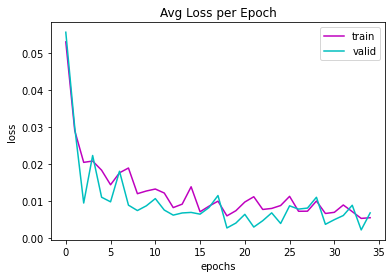

In [100]:
# plot results
plt.plot(train_loss, color='m', label='train')
plt.plot(val_loss, color='c', label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Avg Loss per Epoch')
plt.legend();

In [102]:
min(val_loss)

0.0022482878328966244

In [104]:
# place resent back on cpu and in eval mode
resnet = resnet.to('cpu')
resnet.eval()

test_images, test_outputs, gt_pts = get_sample_output(resnet)

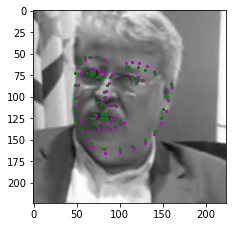

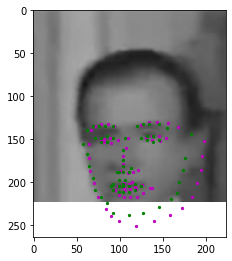

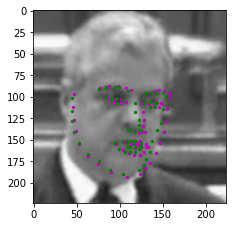

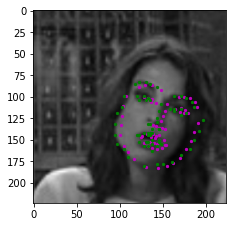

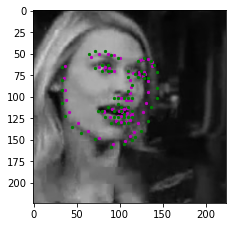

In [105]:
visualize_output(test_images, test_outputs, gt_pts)

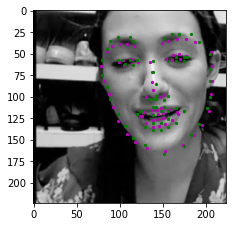

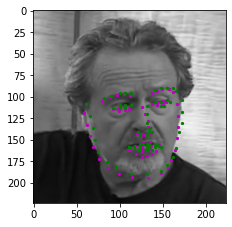

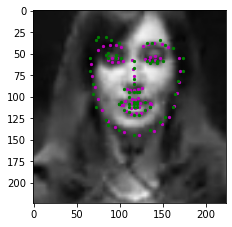

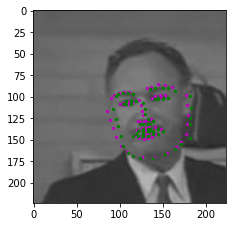

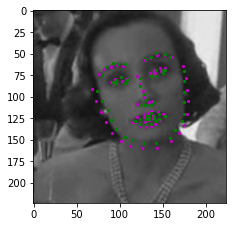

In [106]:
best_resnet = torch.load('models//best_resnet.pth')

best_resnet = best_resnet.to('cpu')
best_resnet.eval()

test_images, test_outputs, gt_pts = get_sample_output(best_resnet)
visualize_output(test_images, test_outputs, gt_pts)

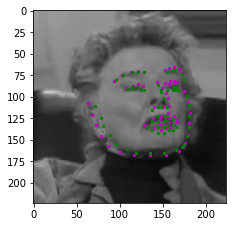

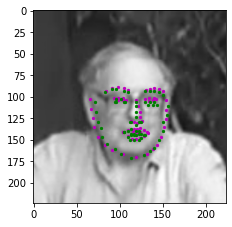

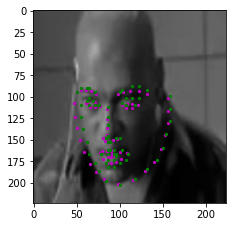

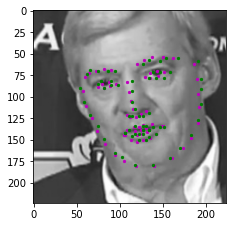

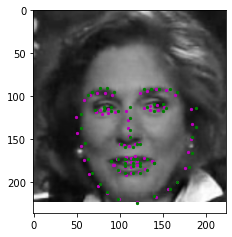

In [107]:
test_images, test_outputs, gt_pts = get_sample_output(best_resnet)
visualize_output(test_images, test_outputs, gt_pts)

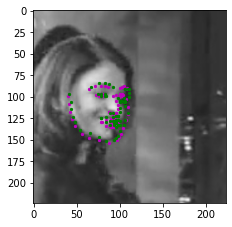

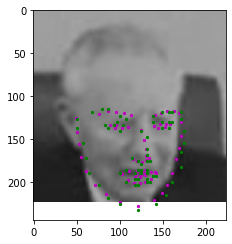

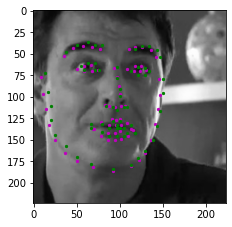

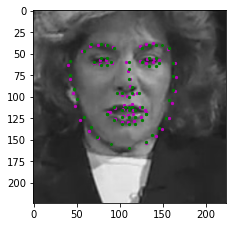

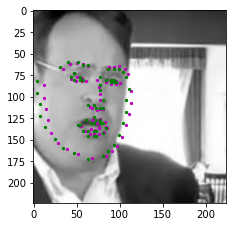

In [108]:
test_images, test_outputs, gt_pts = get_sample_output(best_resnet)
visualize_output(test_images, test_outputs, gt_pts)